In [1]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms

from models import vit, efficientNet
batch_size = 32

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [14]:
vit_model = vit().to(device)

In [15]:
vit_model.load_state_dict(torch.load("output_vit_1000/best_checkpoint.pt"))

<All keys matched successfully>

In [3]:
effNet_model = efficientNet("output_eff_1000/best_checkpoint.pt").to(device)

In [4]:
test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [5]:
test_dir = 'dataset/real_test'
test_image_datasets = datasets.ImageFolder(test_dir, test_transforms)

In [6]:
test_loader = torch.utils.data.DataLoader(test_image_datasets,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=2)

In [7]:
model = effNet_model

In [24]:
model.eval()

running_corrects = 0
count = 0

y_pred = []
y_true = []

mispredicted = []
mispredicted_lbls = []
confidence = []

with torch.no_grad():
# Iterate over data.
    for inputs, labels in test_loader:
        input = inputs.to(device)
        labels = labels.to(device)

        outputs = model(input)
        outputs = torch.sigmoid(outputs)
        max_vals, preds = torch.max(outputs, 1)

        # statistics
        
        running_corrects += torch.sum(preds == labels.data).item()

        preds = preds.cpu().numpy()
        labels = labels.data.cpu().numpy()

        input_cpu = input.cpu().numpy()
        mispredicted.append(input_cpu[preds != labels.data])
        mispredicted_lbls.append(preds[preds != labels.data])
        confidence.append(max_vals.cpu().numpy()[preds != labels.data])

        count += preds.shape[0]

        y_pred.extend(preds)
        y_true.extend(labels) # Save Truth

    epoch_acc = running_corrects / max(count, 1)

In [14]:
mispredicted[0].shape

(19, 3, 224, 224)

In [15]:
import torchshow as ts

[1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1]
[0.99716514 0.84633625 0.9841457  0.9712994  0.9931252  0.9342132
 0.998882   0.97309506 0.8942256  0.99982184 0.9966536  0.983441
 0.908495   0.6777846  0.9130599  0.818781   0.9633088  0.9925965
 0.9966562 ]
[1 1 1 1 1 1 1 1 1 1 1 2]
[0.8953576  0.9497156  0.90508896 0.87240374 0.9359174  0.5553704
 0.99755114 0.99374795 0.97171426 0.87611425 0.9451795  0.7715329 ]
[1 1 1 1 1 1 1 1 1]
[0.9995372  0.9994997  0.9624654  0.48509613 0.95812494 0.995641
 0.9983234  0.99401337 0.99627846]
[1 1 1 1]
[0.9972006  0.97823745 0.7098433  0.9924891 ]
[2]
[0.9553405]
[2 2 2]
[0.7344181  0.90672755 0.9176807 ]
[2 2]
[0.8925754 0.8751569]
[1 1 1 1 1]
[0.9917562 0.9789348 0.7363141 0.8997847 0.9759948]
[1 1 1]
[0.7315398  0.9778088  0.82020915]
[1 1 1 1 1]
[0.9831988  0.96322346 0.9111566  0.807525   0.8355261 ]
[1 1 1 1 1 1]
[0.8026723  0.97725874 0.83296686 0.822528   0.9743301  0.813015  ]
[1 1]
[0.7775868  0.94192594]


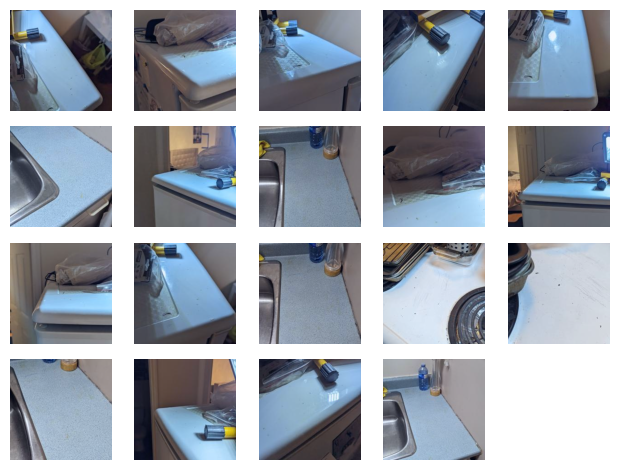

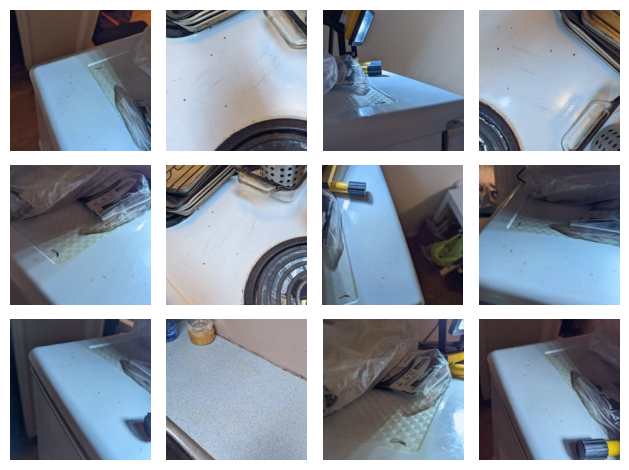

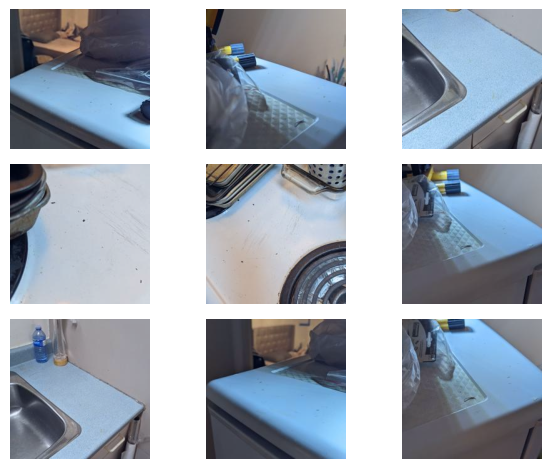

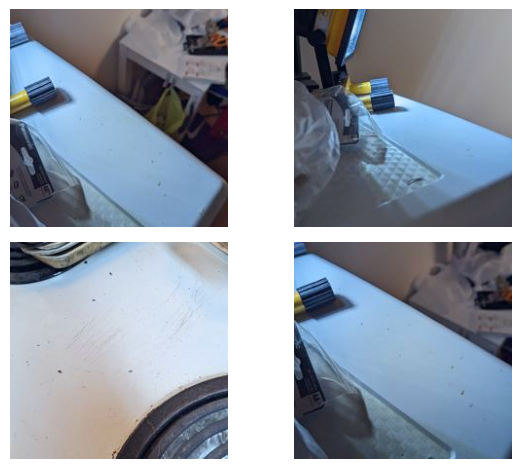

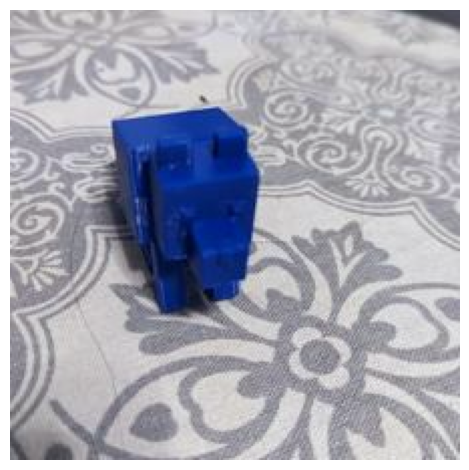

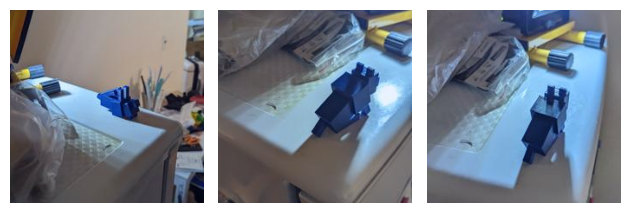

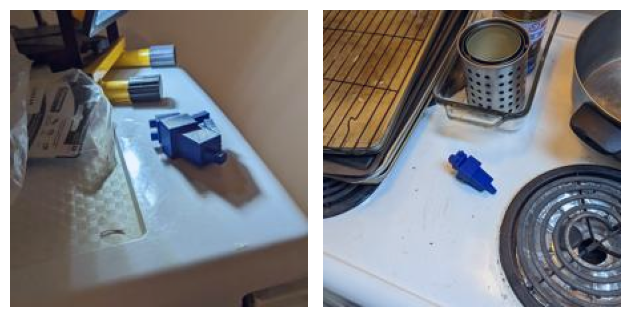

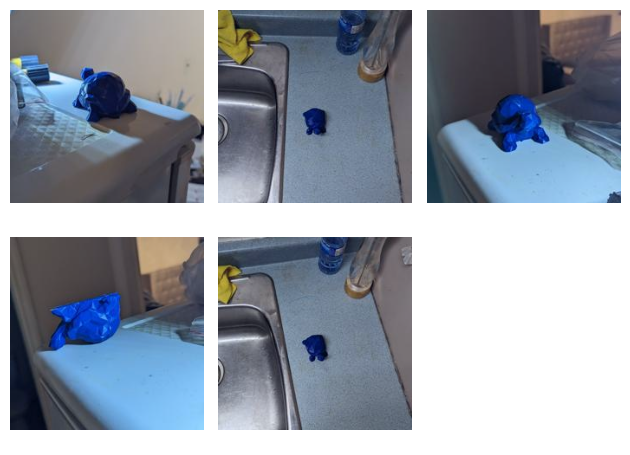

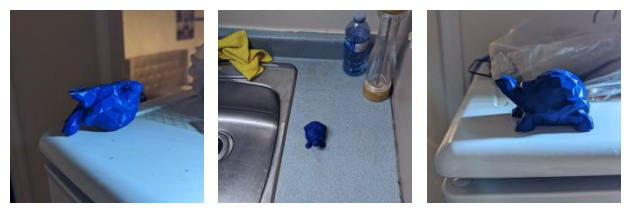

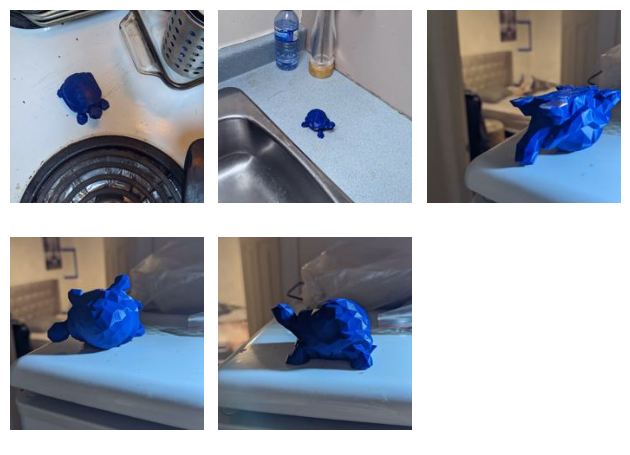

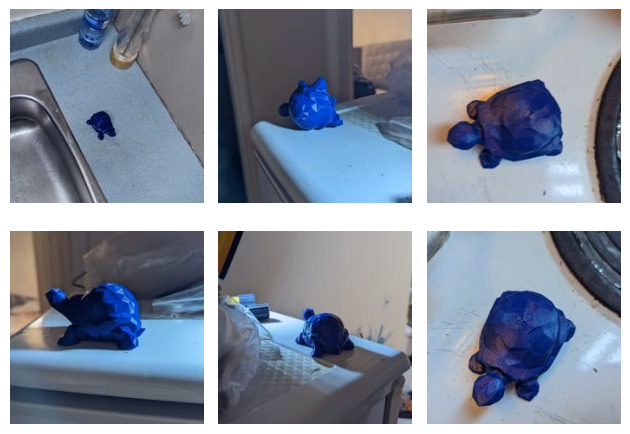

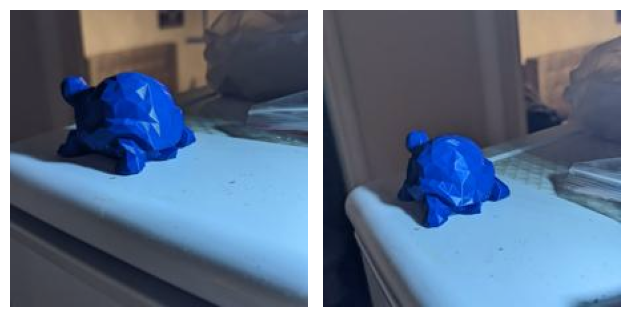

In [25]:
for i in range(len(mispredicted)):
    if len(mispredicted[i]) == 0:
        continue
    
    batch = mispredicted[i]
    print(mispredicted_lbls[i])
    print(confidence[i])
    ts.show(batch)


In [26]:
epoch_acc

0.836027713625866

In [ ]:
test_loader.dataset.classes

['bg', 'dog', 'turtle']

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classes = test_loader.dataset.classes
cf_matrix = confusion_matrix(y_true, y_pred)

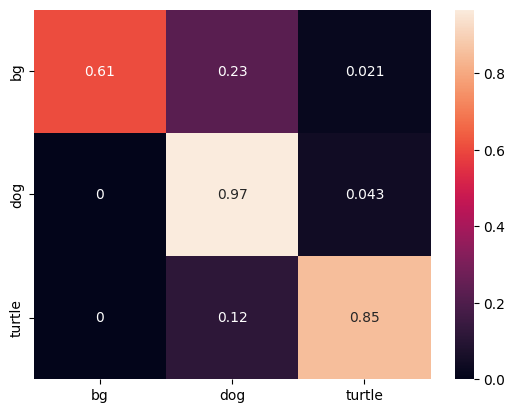

In [12]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure()
sn.heatmap(df_cm, annot=True)
plt.show()
